* Reference to [PyTorch Custom Dataset Examples](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)
* Reference to [PyTorch docs](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* Inspired by https://github.com/NeuroSYS-pl/objects_counting_dmap/blob/HEAD/data_loader.py

In [44]:
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import colors

import torch 
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Custom Dataset 

In [45]:
class H5Dataset(Dataset): 
    # PyTorch dataset for HDF5 files
    # ------------------------------
    def __init__(self, 
                path:str,
                transform=None):
        """
        Args: 
            path: a path to a HDF5 file
        """
        super(H5Dataset, self).__init__()
        self.h5 = h5py.File(path, 'r')  # path in read
        self.images = self.h5['images']
        self.labels = self.h5['labels']

        self.T = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx:int):
        img = self.images[idx].transpose(1,2,0) # (C,H,W) -> (H,W,C)
        label = self.labels[idx] # (1, H, W)

        if self.T:
            label = self.labels[idx].squeeze() # (1, H, W) -> (H, W)
            transformed = self.T(image=img, mask=label)
            return transformed["image"], transformed["mask"].unsqueeze(dim=0) 

        return img, label

## DataLoader 

In [46]:
train_path = r"../Dataset/mall/train.h5"

T = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=35, p=0.5),
        A.VerticalFlip(p=0.5),
#        A.Normalize(mean=[0.43216, 0.394666, 0.37645], 
#                    std=[0.22803, 0.22145, 0.216989], 
#                    max_pixel_value=255.),
        ToTensorV2()
        ])

train_data = H5Dataset(path=train_path, transform=T)
train_loader = DataLoader(train_data, batch_size=1, num_workers=4)

In [47]:
check_img, check_label = train_data[5]

check_img = check_img.permute(1,2,0).numpy() 
check_label = check_label.permute(1,2,0).numpy()

print(check_img.shape)
print(check_label.shape)

(480, 640, 3)
(480, 640, 1)


* [image denormalization](https://stackoverflow.com/questions/30047612/how-to-denormalize-image-in-python)

In [48]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

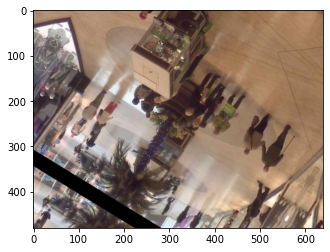

In [49]:
plt.imshow(check_img)
plt.show()

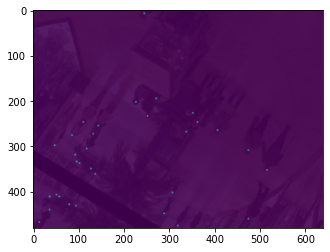

In [50]:
plt.imshow(check_img)
plt.imshow(check_label, alpha=0.9)
plt.show()

In [51]:
# dataloader 
image, label = next(iter(train_loader))

print(image.size())
print(label.size())

torch.Size([1, 3, 480, 640])
torch.Size([1, 1, 480, 640])
